<a href="https://colab.research.google.com/github/Ignacioelamo/LLMs4Phishing/blob/main/01_data_cleaning_and_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Limpieza de datasets

## Descargas

In [5]:
!pip install langdetect

In [6]:
!pip install --upgrade kagglehub

## Librerías

In [7]:
import os
from pathlib import Path

import gdown

import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

import re
import requests


from bs4 import BeautifulSoup
from email.parser import BytesParser
from email.policy import default as default_policy # Renamed for clarity
from email.header import decode_header

import kagglehub
from kagglehub import KaggleDatasetAdapter

## Constantes

In [8]:
MAX_WORDS = 300
MIN_WORDS = 50

# Muestras de phising: 5000
SAMPLE_SIZE_TREC_PHIS = 800
SAMPLE_SIZE_CEAS_PHIS = 800
SAMPLE_SIZE_ENRON_PHIS = 800
SAMPLE_SIZE_NIGERIAN = 630
SAMPLE_SIZE_NAZARIO = 450
SAMPLE_SIZE_SPAMASSASIN_PHIS = 270
SAMPLE_SIZE_LING_PHIS = 140
SAMPLE_SIZE_PHISING_POT = 1110


# Muestras de ham: 5000
SAMPLE_SIZE_TREC_HAM = 1150 #800
SAMPLE_SIZE_CEAS_HAM = 1150  #800
SAMPLE_SIZE_ENRON_HAM = 1150 #800
SAMPLE_SIZE_SPAMASSASIN_HAM = 1150 #270
SAMPLE_SIZE_LING_HAM = 400        #140

DATA_DIR = Path('./data')
DATA_DIR.mkdir(exist_ok=True)

EML_DIR = Path('./phishing_pot/email')
MERGED_DATASET = 'emails_unificados.csv'

DATA_CEAS = DATA_DIR / 'ceas_08.csv'
DATA_ENRON = DATA_DIR / 'enron.csv'
DATA_LING = DATA_DIR / 'ling.csv'
DATA_NAZARIO = DATA_DIR / 'nazario.csv'
DATA_NIGERIAN = DATA_DIR / 'nigerian_fraud.csv'
DATA_SPAMASSASSIN = DATA_DIR / 'spamassasin.csv'
DATA_TREC = DATA_DIR / 'trec_2007.csv'
DATA_PHISING_POT = 'phishing_pot.csv'

URL_PATTERN = re.compile(
    r'(https?://\S+|www\.\S+|\S+\.(?:com|org|net|info|ru|es|xyz|top|biz|online|site|co|uk|us|io|de|fr))\b',
    re.IGNORECASE
)

PLACEHOLDER_DOMAIN = "example.com"

## GitHub (Phising Pot)

In [9]:
!git clone https://github.com/rf-peixoto/phishing_pot

Cloning into 'phishing_pot'...
remote: Enumerating objects: 5990, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 5990 (delta 24), reused 3 (delta 3), pack-reused 5765 (from 5)
Receiving objects: 100% (5990/5990), 89.57 MiB | 9.94 MiB/s, done.
Resolving deltas: 100% (2132/2132), done.
Updating files: 100% (4635/4635), done.


### Kaggle (Resto de Dataset)

#### Todos los datasets menos el TREC

 [Enlace al Dataset](https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset/data?select=phishing_email.csv)

In [10]:
# Nombres de archivo de Kaggle y los nombres locales deseados
# (Kaggle_filename, local_filename_in_DATA_DIR)
files_to_process = [
    ("CEAS_08.csv", "ceas_08.csv"),
    ("Enron.csv", "enron.csv"),
    ("Ling.csv", "ling.csv"),
    ("Nazario.csv", "nazario.csv"),
    ("Nigerian_Fraud.csv", "nigerian_fraud.csv"),
    ("SpamAssasin.csv", "spamassasin.csv")
]

# Handle del dataset en Kaggle
kaggle_dataset_handle = "naserabdullahalam/phishing-email-dataset"

print(f"Directorio de datos: {DATA_DIR.resolve()}")
print(f"Procesando archivos desde Kaggle dataset: {kaggle_dataset_handle}\n")

# --- Bucle para cargar y guardar cada archivo ---
for kaggle_file, local_file_name in files_to_process:
    print(f"Procesando '{kaggle_file}'...")

    # Construir la ruta completa para guardar el archivo localmente
    local_save_path = DATA_DIR / local_file_name

    try:
        # Cargar el dataset desde Kaggle
        print(f"  Cargando '{kaggle_file}' desde Kaggle...")
        df = kagglehub.load_dataset(
            kagglehub.KaggleDatasetAdapter.PANDAS,
            kaggle_dataset_handle,
            kaggle_file  # <--- CORRECCIÓN AQUÍ: kaggle_file como argumento posicional
        )
        print(f"  '{kaggle_file}' cargado exitosamente como DataFrame.")
        df.to_csv(local_save_path, index=False) # index=False para no guardar el índice de pandas en el CSV
        print(f"  '{local_file_name}' guardado exitosamente en '{DATA_DIR}'.\n")

    except Exception as e:
        print(f"  ERROR al procesar '{kaggle_file}': {e}\n")

print("Proceso completado.")

# --- Verificación opcional: Listar archivos en DATA_DIR ---
print("\nArchivos en el directorio DATA_DIR:")
for item in DATA_DIR.iterdir():
    if item.is_file():
        print(item.name)

Directorio de datos: /content/data
Procesando archivos desde Kaggle dataset: naserabdullahalam/phishing-email-dataset

Procesando 'CEAS_08.csv'...
  Cargando 'CEAS_08.csv' desde Kaggle...


<ipython-input-10-a5f0e528c81d>:28: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


  'CEAS_08.csv' cargado exitosamente como DataFrame.
  'ceas_08.csv' guardado exitosamente en 'data'.

Procesando 'Enron.csv'...
  Cargando 'Enron.csv' desde Kaggle...


<ipython-input-10-a5f0e528c81d>:28: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


  'Enron.csv' cargado exitosamente como DataFrame.
  'enron.csv' guardado exitosamente en 'data'.

Procesando 'Ling.csv'...
  Cargando 'Ling.csv' desde Kaggle...


<ipython-input-10-a5f0e528c81d>:28: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


  'Ling.csv' cargado exitosamente como DataFrame.
  'ling.csv' guardado exitosamente en 'data'.

Procesando 'Nazario.csv'...
  Cargando 'Nazario.csv' desde Kaggle...


<ipython-input-10-a5f0e528c81d>:28: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


  'Nazario.csv' cargado exitosamente como DataFrame.
  'nazario.csv' guardado exitosamente en 'data'.

Procesando 'Nigerian_Fraud.csv'...
  Cargando 'Nigerian_Fraud.csv' desde Kaggle...


<ipython-input-10-a5f0e528c81d>:28: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


  'Nigerian_Fraud.csv' cargado exitosamente como DataFrame.
  'nigerian_fraud.csv' guardado exitosamente en 'data'.

Procesando 'SpamAssasin.csv'...
  Cargando 'SpamAssasin.csv' desde Kaggle...


<ipython-input-10-a5f0e528c81d>:28: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


  'SpamAssasin.csv' cargado exitosamente como DataFrame.
  'spamassasin.csv' guardado exitosamente en 'data'.

Proceso completado.

Archivos en el directorio DATA_DIR:
nigerian_fraud.csv
nazario.csv
ceas_08.csv
enron.csv
ling.csv
spamassasin.csv


#### TREC

 [Enlace al Dataset](https://www.kaggle.com/datasets/imdeepmind/preprocessed-trec-2007-public-corpus-dataset/data)

In [11]:
# --- Procesamiento del segundo dataset: "imdeepmind/preprocessed-trec-2007-public-corpus-dataset" ---

# Nombre del archivo de Kaggle y nombre local deseado
kaggle_file_trec = "processed_data.csv" # Asumiendo que es .csv, ajusta si es necesario
local_file_name_trec = "trec_2007.csv" # Nombre para guardarlo localmente

# Handle del dataset en Kaggle
kaggle_dataset_handle_trec = "imdeepmind/preprocessed-trec-2007-public-corpus-dataset"

print(f"\nProcesando archivo del Kaggle dataset: {kaggle_dataset_handle_trec}\n")

# --- Cargar y guardar el archivo del dataset TREC 2007 ---
print(f"Procesando '{kaggle_file_trec}' del dataset '{kaggle_dataset_handle_trec}'...")
local_save_path_trec = DATA_DIR / local_file_name_trec

try:
    print(f"  Cargando '{kaggle_file_trec}' desde Kaggle...")
    df_trec = kagglehub.load_dataset(
        kagglehub.KaggleDatasetAdapter.PANDAS,
        kaggle_dataset_handle_trec,
        kaggle_file_trec # Para este dataset, puede que necesites especificar 'file_path'
                                    # o simplemente pasarlo como argumento posicional si es el único/principal.
                                    # Revisa la documentación del dataset en Kaggle si da error.
    )
    print(f"  '{kaggle_file_trec}' cargado exitosamente como DataFrame.")
    df_trec.to_csv(local_save_path_trec, index=False)
    print(f"  '{local_file_name_trec}' guardado exitosamente en '{DATA_DIR}'.\n")

except Exception as e:
    print(f"  ERROR al procesar '{kaggle_file_trec}': {e}\n")


print("Proceso del dataset TREC 2007 completado.")
print("-" * 50) # Separador

# --- Verificación opcional: Listar archivos en DATA_DIR ---
print("\nArchivos en el directorio DATA_DIR:")
for item in DATA_DIR.iterdir():
    if item.is_file():
        print(item.name)

print("\nTodos los procesos completados.")


Procesando archivo del Kaggle dataset: imdeepmind/preprocessed-trec-2007-public-corpus-dataset

Procesando 'processed_data.csv' del dataset 'imdeepmind/preprocessed-trec-2007-public-corpus-dataset'...
  Cargando 'processed_data.csv' desde Kaggle...


<ipython-input-11-e05734da4039>:18: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_trec = kagglehub.load_dataset(


100%|██████████| 167M/167M [00:02<00:00, 64.3MB/s]

Extracting zip of processed_data.csv...


  'processed_data.csv' cargado exitosamente como DataFrame.
  'trec_2007.csv' guardado exitosamente en 'data'.

Proceso del dataset TREC 2007 completado.
--------------------------------------------------

Archivos en el directorio DATA_DIR:
nigerian_fraud.csv
nazario.csv
ceas_08.csv
enron.csv
ling.csv
trec_2007.csv
spamassasin.csv

Todos los procesos completados.


## Semilla

In [12]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

## Funciones auxiliares

### General

Funciones auxiliares generales para cualquier tipo de dataset

#### plot_word_count_histogram

Esta función `plot_word_count_histogram()` genera un histograma de la distribución del número de palabras (`word_count`) en los mensajes, diferenciando visualmente las clases según el valor de la columna `label`.

**Parámetros:**
- `data`: DataFrame de entrada que debe contener las columnas `word_count` y `label`.
- `title`: Título del gráfico.
- `colors`: Tupla con los colores a usar para cada clase (por defecto: celeste para label 0 y coral claro para label 1).



In [13]:
def plot_word_count_histogram(data, title, colors=('skyblue', 'lightcoral')):
    plt.figure(figsize=(10, 6))
    for label, color in zip(data['label'].unique(), colors):
        subset = data[data['label'] == label]
        subset['word_count'].hist(bins=50, alpha=0.5, label=f'Label {label}', color=color)
    plt.title(title)
    plt.xlabel('Número de palabras')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.tight_layout()
    plt.show()

#### detect_language

Esta función `detect_language()` detecta el idioma de un texto utilizando la biblioteca `langdetect`.  
Si el texto no tiene suficiente contenido para determinar el idioma, retorna `'unknown'` en lugar de lanzar un error.

**Parámetros:**
- `text`: Cadena de texto (`str`) que representa el contenido del cual se desea detectar el idioma.



In [14]:
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

### Phising Pot

#### decode_header_value

Esta función `decode_header_value()` decodifica un valor codificado de un encabezado de correo electrónico, manejando múltiples posibles codificaciones y limpiando el texto resultante.

Si el valor proporcionado es `None`, retorna una cadena vacía. Usa `decode_header` de la biblioteca `email.header` para dividir el valor codificado en partes junto con su respectiva codificación. Luego, cada parte se decodifica, utilizando `'utf-8'` como opción por defecto si no se especifica una codificación válida.

Después, el resultado se limpia eliminando saltos de línea, tabulaciones y espacios innecesarios, unificando todo en una sola línea de texto legible.

**Parámetros:**
- `encoded_value`: Cadena de texto (`str`) que representa el valor codificado de un encabezado de correo electrónico, como el asunto o el remitente.

**Retorna:**
- Una cadena de texto (`str`) decodificada y limpia.


In [15]:
def decode_header_value(encoded_value: str) -> str:
    """
    Decodifica un valor de encabezado de correo electrónico.
    Maneja múltiples codificaciones y limpia el resultado.
    """
    if encoded_value is None:
        return ""

    decoded_parts = decode_header(encoded_value)
    decoded_value_str = ""
    for part, charset in decoded_parts:
        if isinstance(part, bytes):
            # Si charset es None o inválido, utf-8 es un fallback razonable
            decoded_value_str += part.decode(charset or "utf-8", errors="replace")
        else:
            decoded_value_str += part

    # Limpiar saltos de línea, tabulaciones y espacios extra
    # La lógica original de split/sort/join por comas se ha eliminado
    # ya que puede corromper el contenido de asuntos u otros campos.
    cleaned_value = re.sub(r'[\s\n\r\t]+', ' ', decoded_value_str).strip()
    return cleaned_value

#### clean_text_content

La función `clean_text_content()` limpia el contenido de un texto aplicando varias transformaciones: convierte todo a minúsculas, elimina los caracteres que no sean letras, números o espacios, y normaliza los espacios múltiples.

Si el valor de entrada no es una cadena, retorna una cadena vacía.

**Parámetros:**
- `text`: Cadena de texto (`str`) que representa el contenido a limpiar.

**Retorna:**
- Una cadena de texto (`str`) en minúsculas, sin caracteres especiales y con espacios normalizados.


In [16]:
def clean_text_content(text: str) -> str:
    """
    Limpia el texto: convierte a minúsculas, elimina caracteres no alfanuméricos
    (excepto espacios) y normaliza los espacios.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # Mantiene letras, números y espacios. Elimina otros caracteres.
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Reemplaza múltiples espacios con uno solo y quita espacios al inicio/final.
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#### parse_email_body_and_extract_features

La función `parse_email_body_and_extract_features()` analiza un mensaje de correo electrónico (`msg`) y extrae información útil del mismo. Su objetivo principal es obtener el cuerpo del correo (priorizando HTML sobre texto plano), detectar si contiene contenido HTML, si tiene archivos adjuntos y extraer todas las URLs presentes en el contenido.

**Comportamiento:**
- Recorre todas las partes del mensaje usando `.walk()`.
- Si una parte es un **adjunto**, extrae su nombre decodificado pero no lo trata como contenido del cuerpo.
- Si encuentra **contenido HTML**, lo procesa con `BeautifulSoup`:
  - Extrae el texto visible.
  - Extrae todas las URLs de etiquetas `<a>` y `<img>`, ignorando enlaces vacíos, `mailto:` o imágenes inline (`data:image`).
- Si no encuentra HTML válido, intenta usar el **texto plano** y también extrae URLs usando una expresión regular (`URL_PATTERN`).
- Si el mensaje **no es multiparte**, maneja el contenido directamente.
- Devuelve un cuerpo final (HTML si se puede, o texto plano), una bandera indicando si contiene HTML, si hay adjuntos, y una lista de URLs extraídas.

**Parámetros:**
- `msg`: Objeto de correo electrónico (`email.message.Message`) a analizar. Puede ser multiparte o contener solo texto plano o HTML.

**Retorna:**
- Un diccionario (`dict`) con los siguientes campos:
  - `'body'`: Texto del cuerpo del correo como cadena (`str`).
  - `'contains_html'`: `True` si el cuerpo contiene contenido HTML, `False` en caso contrario.
  - `'has_attachment'`: `True` si el mensaje tiene adjuntos, `False` en caso contrario.
  - `'urls'`: Lista ordenada de URLs (`list[str]`) extraídas del contenido del correo.


In [17]:
def parse_email_body_and_extract_features(msg) -> dict:
    """
    Extrae el cuerpo del email (priorizando HTML), indica si contiene HTML,
    si tiene adjuntos y extrae todas las URLs.
    """
    body_html_str = None
    body_plain_str = None
    extracted_urls = set()
    attachment_filenames = []
    contains_html = False

    for part in msg.walk():
        content_type = part.get_content_type()
        content_disposition = str(part.get("Content-Disposition", "")) # Evitar None

        is_attachment = "attachment" in content_disposition.lower()

        if is_attachment:
            filename = part.get_filename()
            if filename:
                decoded_filename = decode_header_value(filename)
                if decoded_filename: # Asegurarse que no sea vacío
                    attachment_filenames.append(decoded_filename)
            continue # Es un adjunto, no procesar como cuerpo

        # Priorizar el primer contenido HTML que no sea adjunto
        if content_type == "text/html" and body_html_str is None:
            contains_html = True
            try:
                payload = part.get_payload(decode=True)
                charset = part.get_content_charset() or "utf-8"
                html_content = payload.decode(charset, errors="replace")

                soup = BeautifulSoup(html_content, "html.parser")

                # Extraer URLs y modificar el texto para incluir marcadores
                for a_tag in soup.find_all("a", href=True):
                    href = a_tag.get('href')
                    if href and href.strip() and href.strip() != "#" and not href.lower().startswith("mailto:"):
                        extracted_urls.add(href.strip())
                    # Modificar el texto del enlace para incluir la URL (opcional, pero informativo)
                    # a_tag.string = f"{a_tag.get_text(strip=True)} [URL: {href}]"

                for img_tag in soup.find_all("img", src=True):
                    src = img_tag.get('src')
                    if src and not src.lower().startswith("data:image"):
                        extracted_urls.add(src.strip())
                    # Considerar reemplazar <img> con texto alternativo o marcador si se desea
                    # img_tag.replace_with(f"")

                body_html_str = soup.get_text(separator=" ", strip=True)
            except Exception: # pragma: no cover
                # Si falla el parseo de HTML, se intentará con texto plano si existe
                body_html_str = None
                contains_html = False # Revertir si el parseo falló

        # Tomar el primer contenido de texto plano si no se encontró HTML o falló
        elif content_type == "text/plain" and body_plain_str is None:
            try:
                payload = part.get_payload(decode=True)
                charset = part.get_content_charset() or "utf-8"
                plain_content = payload.decode(charset, errors="replace")
                body_plain_str = plain_content
                # Extraer URLs del texto plano
                for match in URL_PATTERN.finditer(plain_content):
                    extracted_urls.add(match.group(0))
            except Exception: # pragma: no cover
                body_plain_str = None

    # Fallback para mensajes no multipartes
    if not msg.is_multipart() and body_html_str is None and body_plain_str is None:
        content_type = msg.get_content_type()
        try:
            payload = msg.get_payload(decode=True)
            charset = msg.get_content_charset() or "utf-8"
            content = payload.decode(charset, errors="replace")

            if content_type == "text/html":
                contains_html = True
                soup = BeautifulSoup(content, "html.parser")
                for a_tag in soup.find_all("a", href=True):
                    href = a_tag.get('href')
                    if href and href.strip() and href.strip() != "#" and not href.lower().startswith("mailto:"):
                        extracted_urls.add(href.strip())
                for img_tag in soup.find_all("img", src=True):
                    src = img_tag.get('src')
                    if src and not src.lower().startswith("data:image"):
                        extracted_urls.add(src.strip())
                body_html_str = soup.get_text(separator=" ", strip=True)
            elif content_type == "text/plain":
                body_plain_str = content
                for match in URL_PATTERN.finditer(content):
                    extracted_urls.add(match.group(0))
        except Exception: # pragma: no cover
            pass # No se pudo extraer contenido

    # Determinar el cuerpo final y si tiene adjuntos
    final_body = body_html_str if body_html_str is not None else body_plain_str
    final_body = final_body or "" # Asegurar que sea string

    has_attachment = bool(attachment_filenames)

    # Opcional: Añadir información de adjuntos al cuerpo
    # if has_attachment:
    #     final_body += f"\n\n[ADJUNTOS: {', '.join(attachment_filenames)}]"

    return {
        'body': final_body,
        'contains_html': contains_html,
        'has_attachment': has_attachment,
        'urls': sorted(list(extracted_urls)) # Lista ordenada de URLs únicas
    }

#### extract_email_data_from_file

La función `extract_email_data_from_file()` procesa un archivo `.eml` (correo electrónico) y extrae campos relevantes como el asunto, el cuerpo del mensaje, si tiene adjuntos, si contiene HTML y las URLs presentes.

**Comportamiento:**
- Abre y parsea el archivo `.eml` utilizando `BytesParser` con la política por defecto.
- Decodifica el encabezado `Subject`.
- Llama a la función `parse_email_body_and_extract_features()` para obtener el cuerpo, adjuntos, URLs y si contiene HTML.
- Limpia tanto el asunto como el cuerpo utilizando `clean_text_content()` para normalizar el contenido textual.

Si ocurre un error al abrir el archivo, retorna `None`.

**Parámetros:**
- `file_path`: Objeto `Path` que representa la ruta al archivo `.eml` que se desea procesar.

**Retorna:**
- Un diccionario (`dict`) con los siguientes campos:
  - `'subject'`: Texto del asunto, ya limpio (`str`).
  - `'body'`: Texto del cuerpo del correo, limpio y procesado (`str`).
  - `'has_attachment'`: `True` si el correo contiene adjuntos, `False` en caso contrario.
  - `'contains_html'`: `True` si el cuerpo del correo contiene HTML, `False` si es solo texto plano.
  - `'urls'`: Lista de URLs (`list[str]`) extraídas del contenido del correo.


In [18]:
def extract_email_data_from_file(file_path: Path) -> dict:
    """
    Extrae los campos deseados de un único archivo .eml.
    """
    try:
        with open(file_path, "rb") as f:
            msg = BytesParser(policy=default_policy).parse(f)
    except IOError: # pragma: no cover
        # Podrías loggear este error si es necesario
        return None

    subject = decode_header_value(msg["Subject"])

    body_features = parse_email_body_and_extract_features(msg)

    # Aplicar limpieza de texto a subject y body
    cleaned_subject = clean_text_content(subject)
    cleaned_body = clean_text_content(body_features['body'])

    return {
        'subject': cleaned_subject,
        'body': cleaned_body, # Cuerpo ya procesado y limpiado
        'has_attachment': body_features['has_attachment'],
        'contains_html': body_features['contains_html'],
        'urls': body_features['urls'] # Lista de URLs
    }

#### create_phishing_dataset

La función `create_phishing_dataset()` procesa todos los archivos `.eml` dentro de una carpeta específica y construye un `DataFrame` con información estructurada de cada correo, útil para análisis o entrenamiento de modelos de detección de phishing.

**Comportamiento:**
- Recorre todos los archivos `.eml` en la carpeta dada.
- Usa `extract_email_data_from_file()` para extraer y limpiar la información de cada correo.
- Si no se logra procesar ningún archivo, retorna un `DataFrame` vacío con las columnas esperadas.
- Si hay datos válidos:
  - Crea un `DataFrame` con la información extraída.
  - Añade las columnas:
    - `'source'`: Se marca como `"phishing_pot"` para indicar la procedencia del dataset.
    - `'label'`: Se asigna el valor `1` a todos los correos, asumiendo que son phishing.
  - Elimina duplicados basados en el campo `'body'`.
  - Elimina filas cuyo cuerpo esté vacío o sea nulo.
  - Reordena las columnas y reinicia los índices.

**Parámetros:**
- `eml_folder_path`: Objeto `Path` que representa la carpeta que contiene los archivos `.eml` a procesar.

**Retorna:**
- Un `pandas.DataFrame` con las siguientes columnas:
  - `'subject'`: Asunto del correo (`str`).
  - `'body'`: Contenido del cuerpo del correo (`str`).
  - `'has_attachment'`: Indica si tiene adjuntos (`bool`).
  - `'contains_html'`: Indica si contiene HTML (`bool`).
  - `'source'`: Etiqueta de origen (aquí `"phishing_pot"`).
  - `'label'`: Etiqueta binaria (1 = phishing).
  - `'urls'`: Lista de URLs extraídas del contenido del correo.


In [19]:
def create_phishing_dataset(eml_folder_path: Path) -> pd.DataFrame:
    """
    Procesa todos los archivos .eml en la carpeta especificada y crea un DataFrame.
    """
    email_data_list = []

    for file_path in eml_folder_path.glob("*.eml"):
        if file_path.is_file():
            data = extract_email_data_from_file(file_path)
            if data: # Solo añadir si el procesamiento fue exitoso
                email_data_list.append(data)

    if not email_data_list:
        # Devolver DataFrame vacío con las columnas esperadas si no se procesaron emails
        return pd.DataFrame(columns=['subject', 'body', 'has_attachment', 'contains_html', 'source', 'label', 'urls'])

    df = pd.DataFrame(email_data_list)

    # Añadir columnas 'source' y 'label' (vectorizado)
    df['source'] = "phishing_pot"
    df['label'] = 1 # Asumiendo que todos son phishing (label=1)

    # Eliminar duplicados basados en el contenido del cuerpo (opcional, pero común)
    # Puedes ajustar los criterios de duplicados (ej. ['subject', 'body'])
    df.drop_duplicates(subset=['body'], inplace=True)

    # Eliminar filas donde el cuerpo esté vacío después de todo el procesamiento
    df.dropna(subset=['body'], inplace=True)
    df = df[df['body'] != ""] # Adicionalmente, eliminar si el cuerpo es una cadena vacía

    # Reordenar/seleccionar columnas finales
    final_columns = ['subject', 'body', 'has_attachment', 'contains_html', 'source', 'label', 'urls']
    df = df[final_columns]

    df = df.reset_index(drop=True) # Resetear índice después de dropear filas

    return df

## TREC

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [20]:
df_trec = (
    pd.read_csv(DATA_TREC, usecols=['subject', 'message', 'label'])
      .rename(columns={'message': 'body'})
      .assign(body=lambda df: df['body'].astype(str),
        word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

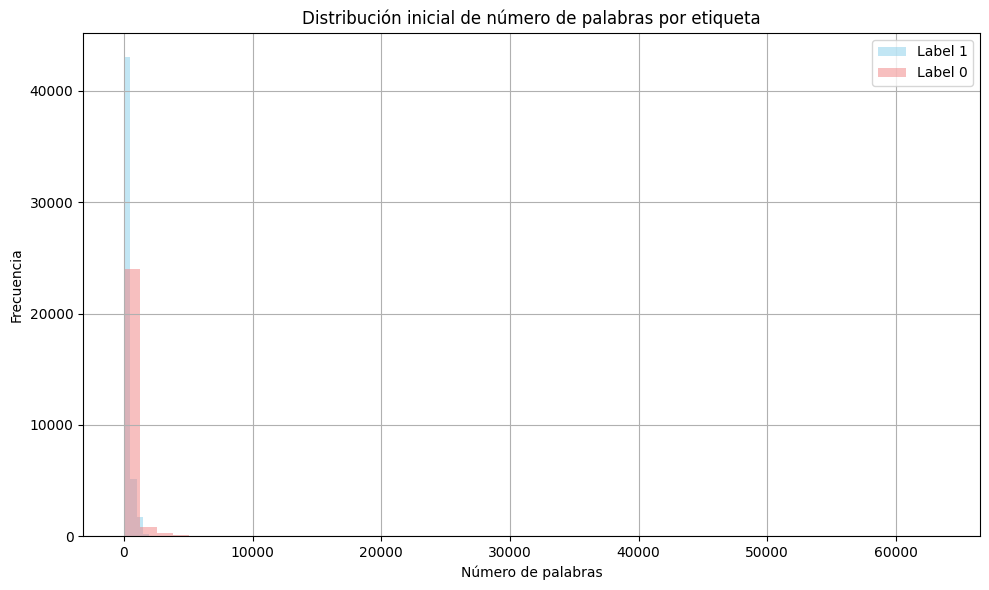

In [21]:
plot_word_count_histogram(df_trec,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


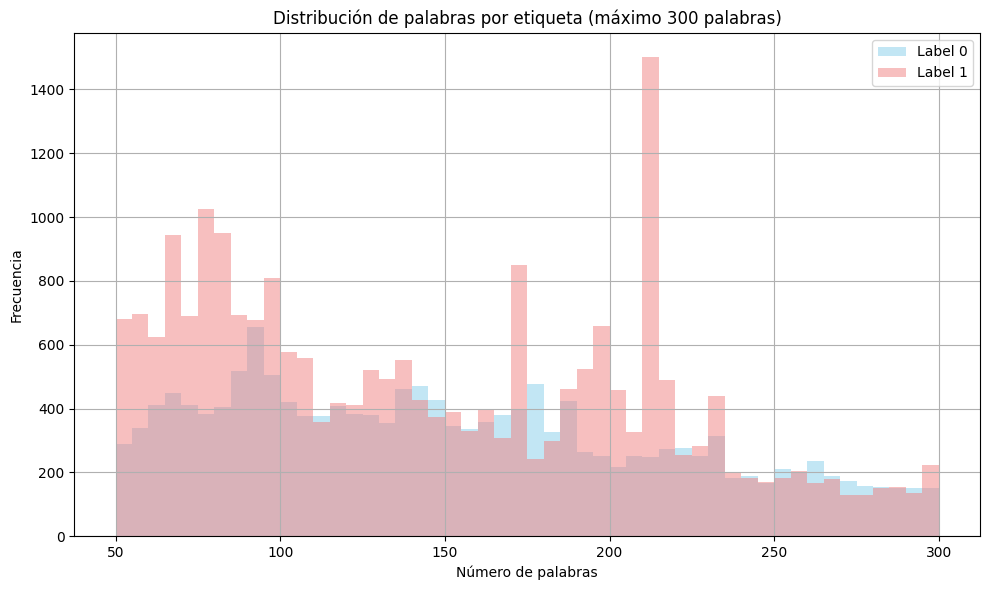

Número de instancias tras filtrado: 39009


In [22]:
df_trec_filtered = df_trec[
    (df_trec['word_count'] <= MAX_WORDS) &
    (MIN_WORDS <= df_trec['word_count'])
].copy()

df_trec_filtered['language'] = df_trec_filtered['body'].apply(detect_language)
df_trec_filtered = df_trec_filtered[df_trec_filtered['language'] == 'en']

plot_word_count_histogram(
    df_trec_filtered,
    f'Distribución de palabras por etiqueta (máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_trec_filtered.shape[0]}")

Seleccionamos los correos que necesitamos de cada tipo de forma aleatoria.


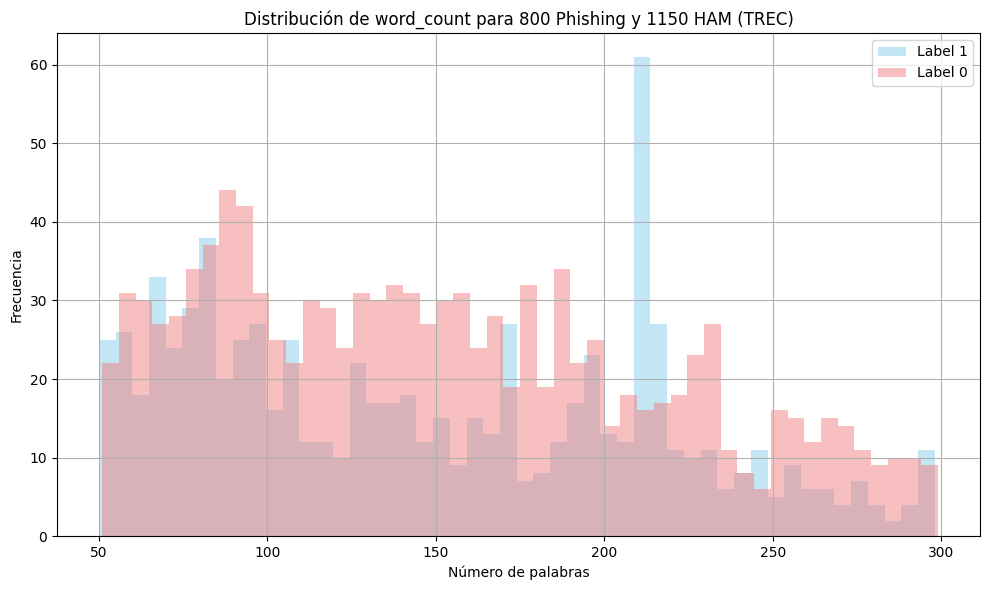

In [23]:
df_phishing_trec = df_trec_filtered[df_trec_filtered['label'] == 1].sample(n=SAMPLE_SIZE_TREC_PHIS, random_state=SEED)
df_ham_trec = df_trec_filtered[df_trec_filtered['label'] == 0].sample(n=SAMPLE_SIZE_TREC_HAM, random_state=SEED)

df_trec = pd.concat([df_phishing_trec, df_ham_trec])

plot_word_count_histogram(df_trec, f'Distribución de word_count para {SAMPLE_SIZE_TREC_PHIS} Phishing y {SAMPLE_SIZE_TREC_HAM} HAM (TREC)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [24]:
df_trec = df_trec.drop(columns=['word_count', 'language'])

print(f"{df_trec.shape=}")


print("\nDistribución final de etiquetas:")
print(df_trec['label'].value_counts())

df_trec.shape=(1950, 3)

Distribución final de etiquetas:
label
0    1150
1     800
Name: count, dtype: int64


## CEAS 08

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [25]:
df_ceas = (
    pd.read_csv(DATA_CEAS, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

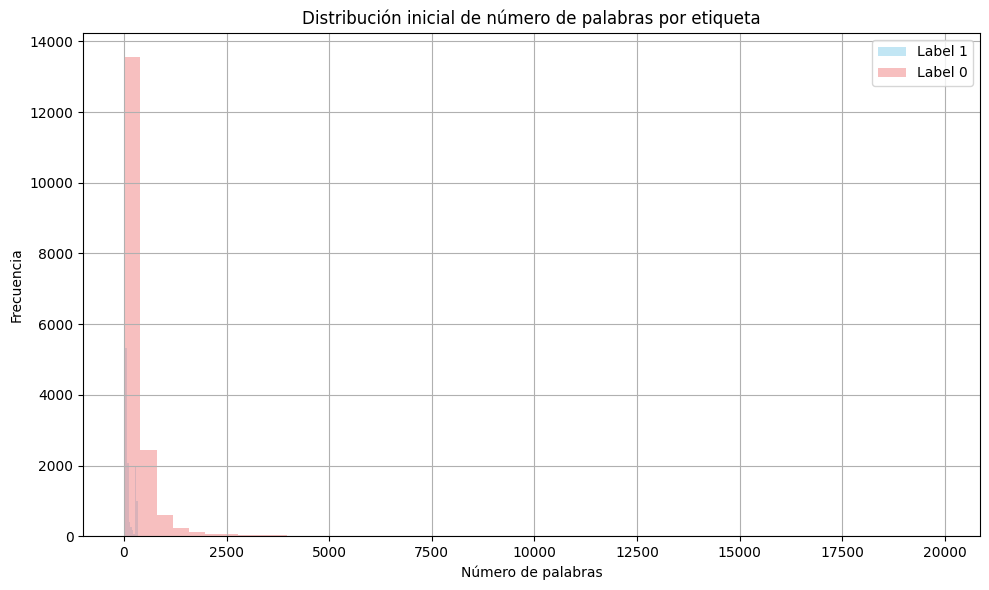

In [26]:
plot_word_count_histogram(df_ceas,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


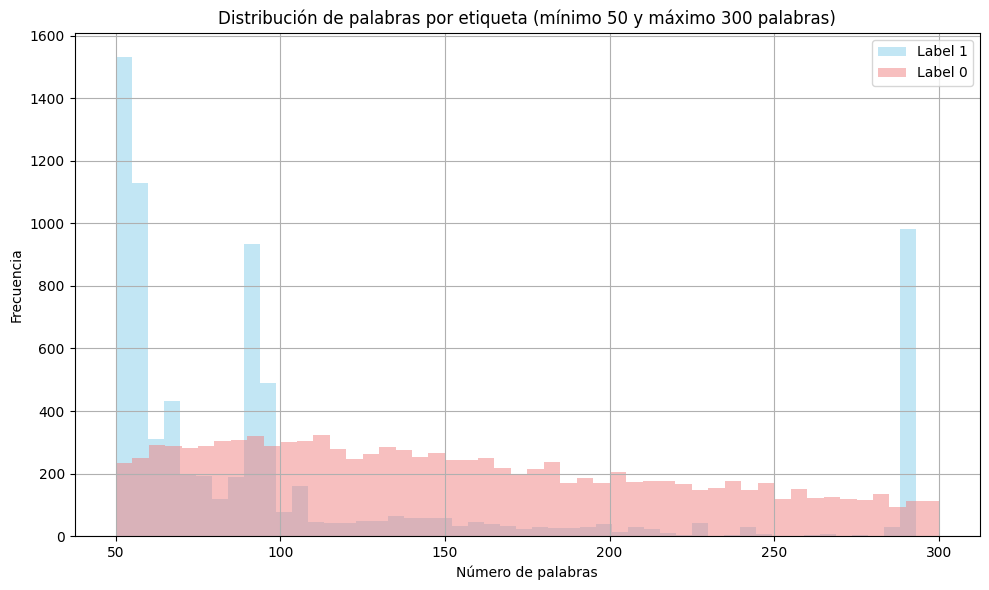

Número de instancias tras filtrado: 18423


In [27]:
df_ceas_filtered = df_ceas[
    (df_ceas['word_count'] <= MAX_WORDS) &
    (df_ceas['word_count'] >= MIN_WORDS)
].copy()

df_ceas_filtered['language'] = df_ceas_filtered['body'].apply(detect_language)
df_ceas_filtered = df_ceas_filtered[df_ceas_filtered['language'] == 'en']

plot_word_count_histogram(
    df_ceas_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_ceas_filtered.shape[0]}")

Seleccionamos los correos que necesitamos de cada tipo de forma aleatoria.


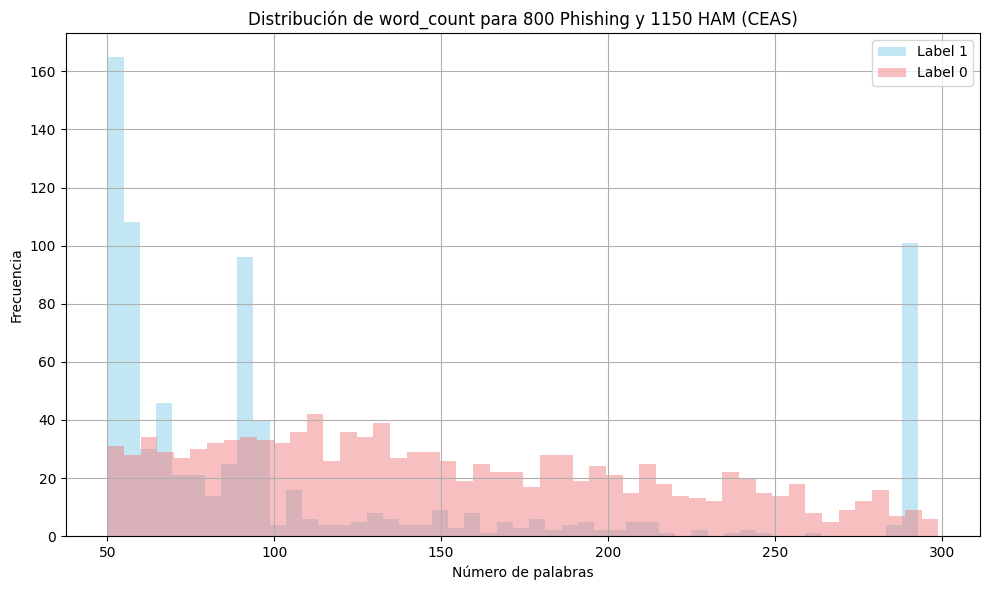

In [28]:
df_phishing_ceas = df_ceas_filtered[df_ceas_filtered['label'] == 1].sample(n=SAMPLE_SIZE_CEAS_PHIS, random_state=SEED)
df_ham_ceas = df_ceas_filtered[df_ceas_filtered['label'] == 0].sample(n=SAMPLE_SIZE_CEAS_HAM, random_state=SEED)

df_ceas = pd.concat([df_phishing_ceas, df_ham_ceas])

plot_word_count_histogram(df_ceas, f'Distribución de word_count para {SAMPLE_SIZE_CEAS_PHIS} Phishing y {SAMPLE_SIZE_CEAS_HAM} HAM (CEAS)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [29]:
df_ceas = df_ceas.drop(columns=['word_count', 'language'])

print(f"{df_ceas.shape=}")


print("\nDistribución final de etiquetas:")
print(df_ceas['label'].value_counts())

df_ceas.shape=(1950, 3)

Distribución final de etiquetas:
label
0    1150
1     800
Name: count, dtype: int64


## ENRON

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [30]:
df_enron = (
    pd.read_csv(DATA_ENRON, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

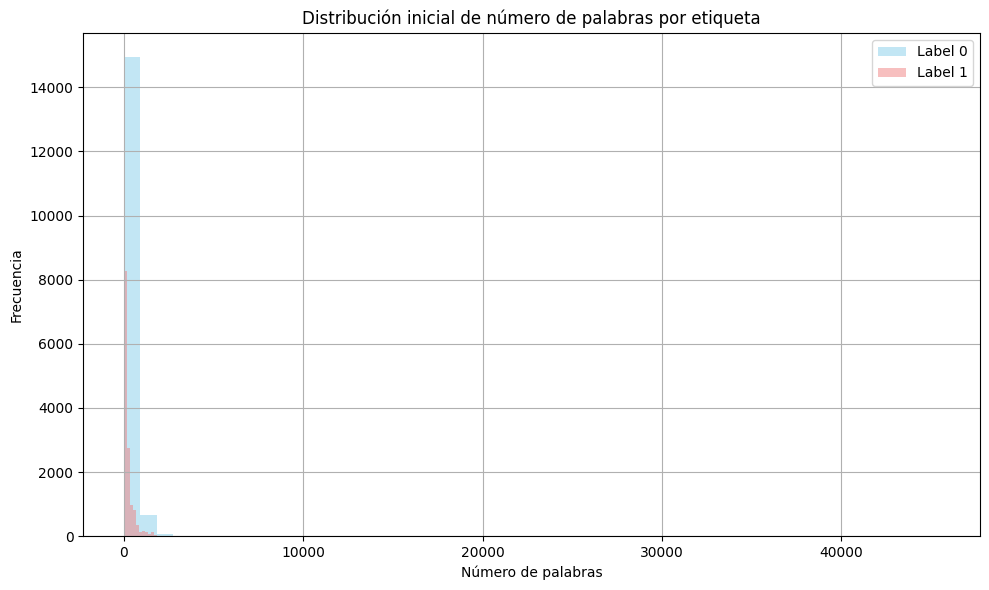

In [31]:
plot_word_count_histogram(df_enron,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


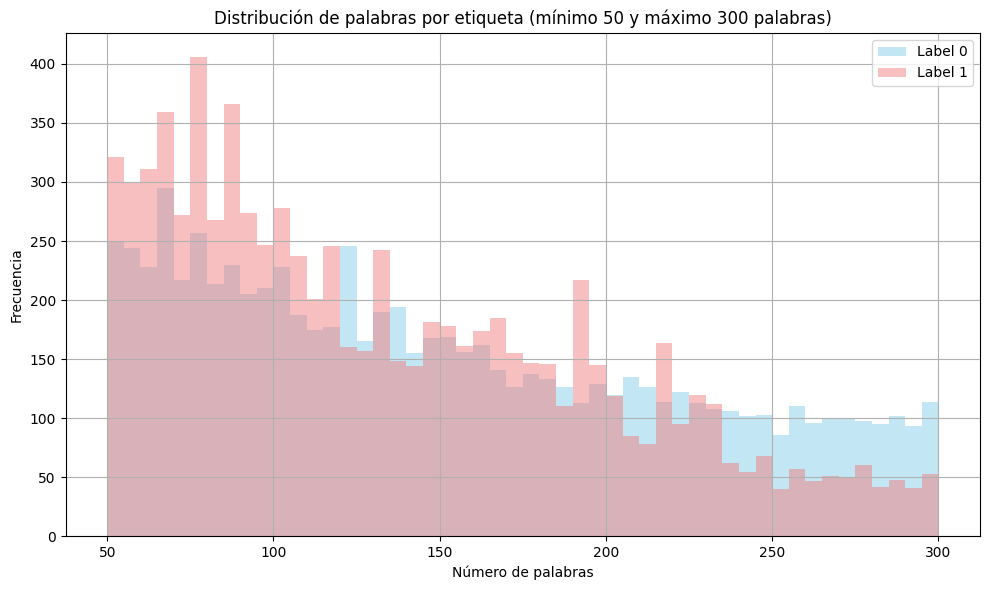

Número de instancias tras filtrado: 15949


In [32]:
df_enron_filtered = df_enron[
    (df_enron['word_count'] <= MAX_WORDS) &
    (df_enron['word_count'] >= MIN_WORDS)
].copy()

df_enron_filtered['language'] = df_enron_filtered['body'].apply(detect_language)
df_enron_filtered = df_enron_filtered[df_enron_filtered['language'] == 'en']

plot_word_count_histogram(
    df_enron_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_enron_filtered.shape[0]}")

Seleccionamos los correos que necesitamos de cada tipo de forma aleatoria.


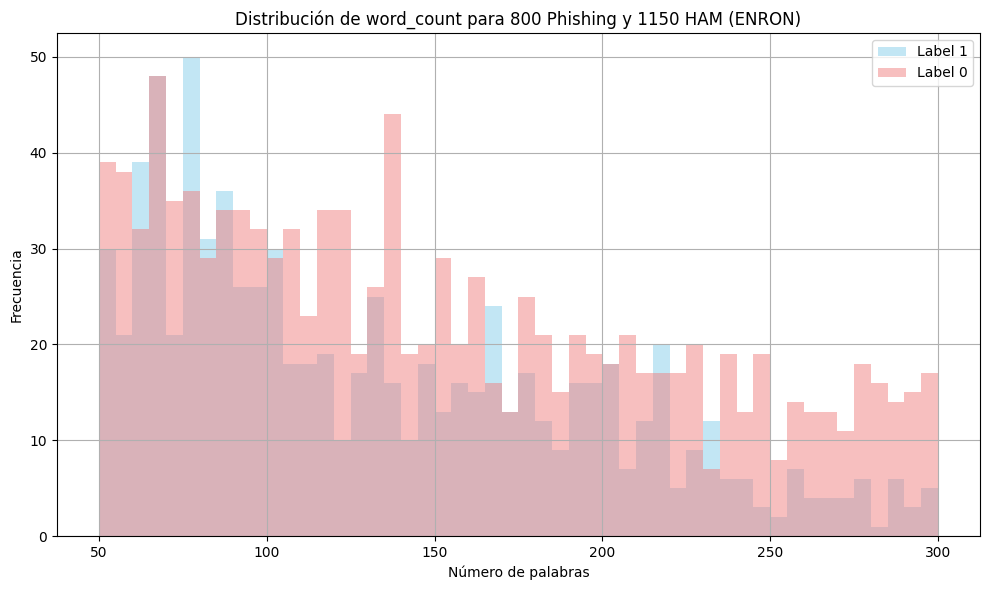

In [33]:
df_phishing_enron = df_enron_filtered[df_enron_filtered['label'] == 1].sample(n=SAMPLE_SIZE_ENRON_PHIS, random_state=SEED)
df_ham_enron = df_enron_filtered[df_enron_filtered['label'] == 0].sample(n=SAMPLE_SIZE_ENRON_HAM, random_state=SEED)

df_enron = pd.concat([df_phishing_enron, df_ham_enron])

plot_word_count_histogram(df_enron, f'Distribución de word_count para {SAMPLE_SIZE_ENRON_PHIS} Phishing y {SAMPLE_SIZE_ENRON_HAM} HAM (ENRON)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [34]:
df_enron = df_enron.drop(columns=['word_count', 'language'])

print(f"{df_enron.shape=}")


print("\nDistribución final de etiquetas:")
print(df_enron['label'].value_counts())

df_enron.shape=(1950, 3)

Distribución final de etiquetas:
label
0    1150
1     800
Name: count, dtype: int64


## SPAMASSASIN

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [35]:
df_spamassasin = (
    pd.read_csv(DATA_SPAMASSASSIN, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

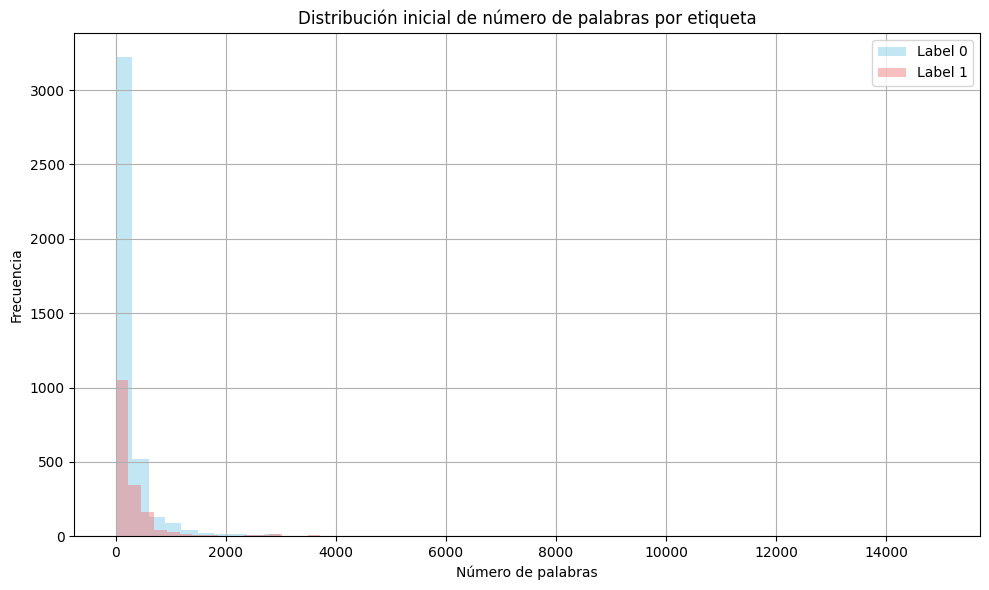

In [36]:
plot_word_count_histogram(df_spamassasin,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


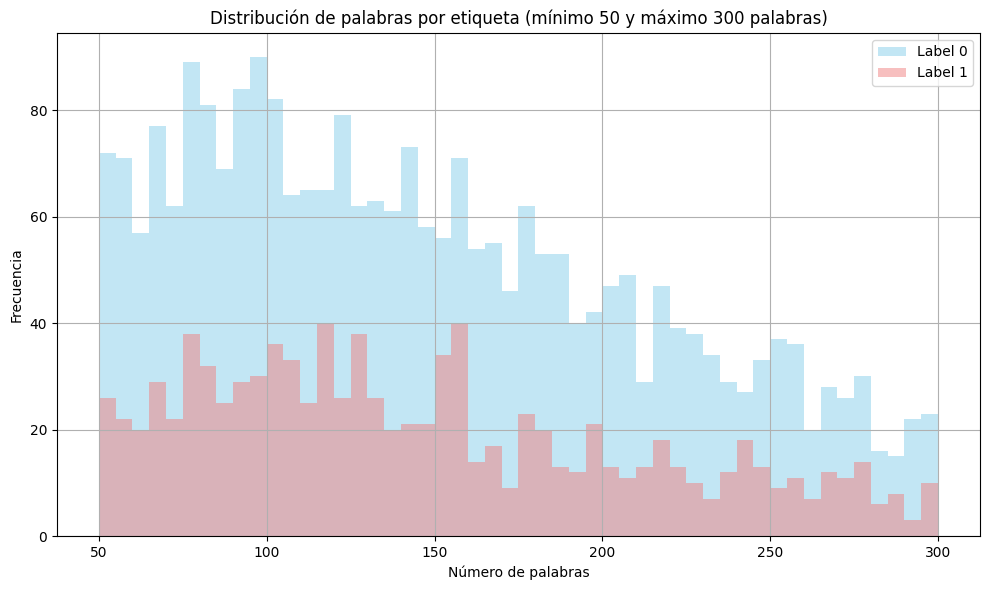

Número de instancias tras filtrado: 3562


In [37]:
df_spamassasin_filtered = df_spamassasin[
    (df_spamassasin['word_count'] <= MAX_WORDS) &
    (df_spamassasin['word_count'] >= MIN_WORDS)
].copy()

df_spamassasin_filtered['language'] = df_spamassasin_filtered['body'].apply(detect_language)
df_spamassasin_filtered = df_spamassasin_filtered[df_spamassasin_filtered['language'] == 'en']

plot_word_count_histogram(
    df_spamassasin_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_spamassasin_filtered.shape[0]}")

Seleccionamos los correos que necesitamos de cada tipo de forma aleatoria.


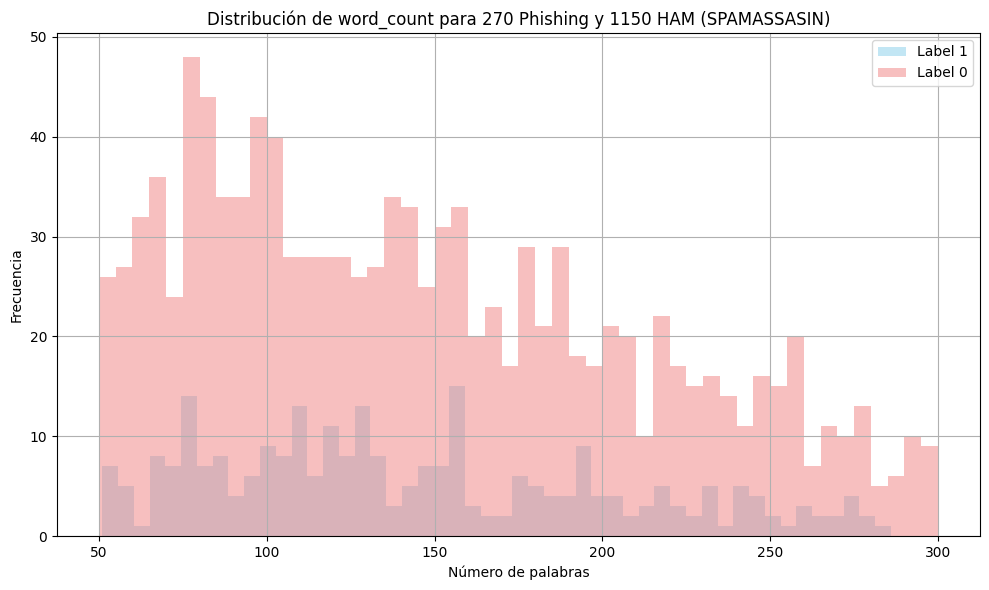

In [38]:
df_phishing_spamassasin = df_spamassasin_filtered[df_spamassasin_filtered['label'] == 1].sample(n=SAMPLE_SIZE_SPAMASSASIN_PHIS, random_state=SEED)
df_ham_spamassasin = df_spamassasin_filtered[df_spamassasin_filtered['label'] == 0].sample(n=SAMPLE_SIZE_SPAMASSASIN_HAM, random_state=SEED)

df_spamassasin = pd.concat([df_phishing_spamassasin, df_ham_spamassasin])

plot_word_count_histogram(df_spamassasin, f'Distribución de word_count para {SAMPLE_SIZE_SPAMASSASIN_PHIS} Phishing y {SAMPLE_SIZE_SPAMASSASIN_HAM} HAM (SPAMASSASIN)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [39]:
df_spamassasin = df_spamassasin.drop(columns=['word_count', 'language'])

print(f"{df_spamassasin.shape=}")


print("\nDistribución final de etiquetas:")
print(df_spamassasin['label'].value_counts())

df_spamassasin.shape=(1420, 3)

Distribución final de etiquetas:
label
0    1150
1     270
Name: count, dtype: int64


## LING

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [40]:
df_ling = (
    pd.read_csv(DATA_LING, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

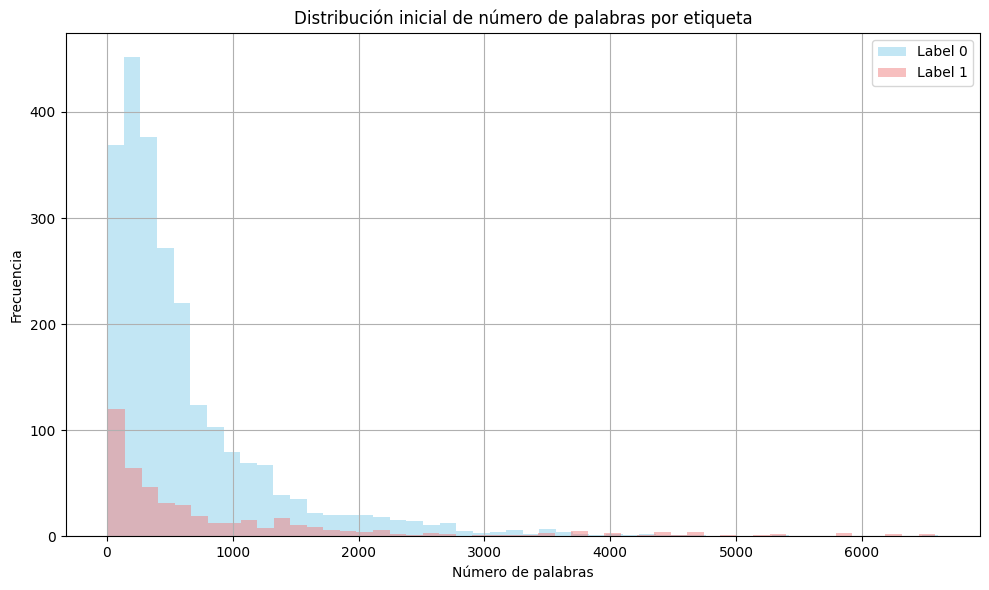

In [41]:
plot_word_count_histogram(df_ling,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


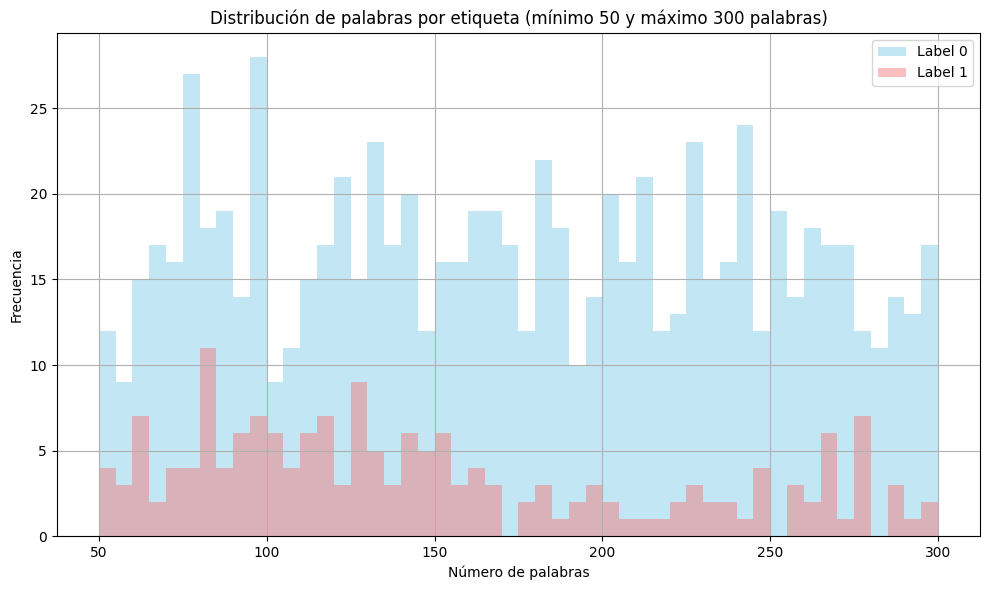

Número de instancias tras filtrado: 999


In [42]:
df_ling_filtered = df_ling[
    (df_ling['word_count'] <= MAX_WORDS) &
    (df_ling['word_count'] >= MIN_WORDS)
].copy()

df_ling_filtered['language'] = df_ling_filtered['body'].apply(detect_language)
df_ling_filtered = df_ling_filtered[df_ling_filtered['language'] == 'en']

plot_word_count_histogram(
    df_ling_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_ling_filtered.shape[0]}")

Seleccionamos los correos que necesitamos de cada tipo de forma aleatoria.

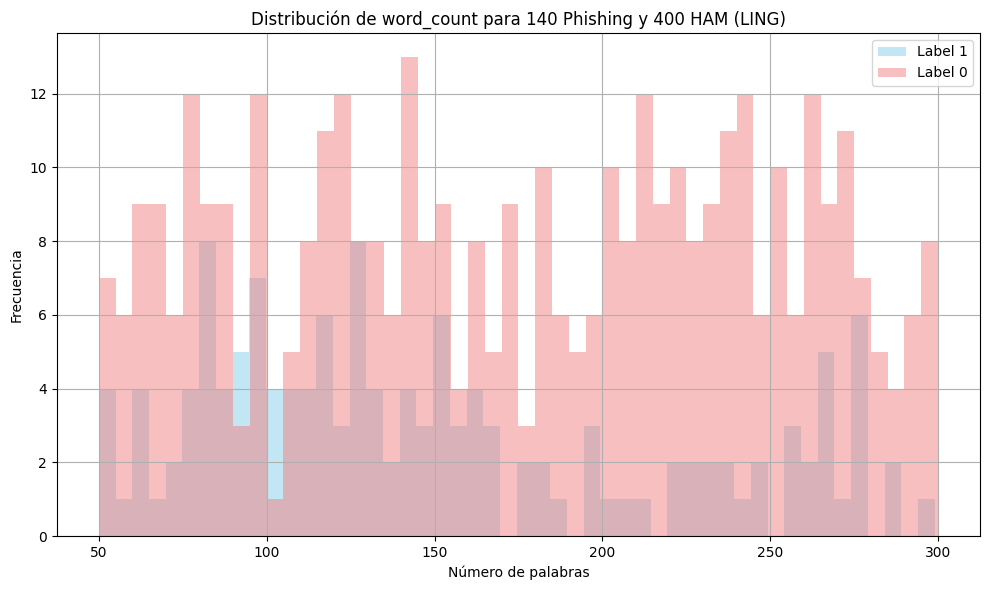

In [43]:
df_phishing_ling = df_ling_filtered[df_ling_filtered['label'] == 1].sample(n=SAMPLE_SIZE_LING_PHIS, random_state=SEED)
df_ham_ling = df_ling_filtered[df_ling_filtered['label'] == 0].sample(n=SAMPLE_SIZE_LING_HAM, random_state=SEED)

df_ling = pd.concat([df_phishing_ling, df_ham_ling])

plot_word_count_histogram(df_ling, f'Distribución de word_count para {SAMPLE_SIZE_LING_PHIS} Phishing y {SAMPLE_SIZE_LING_HAM} HAM (LING)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [44]:
df_ling = df_ling.drop(columns=['word_count', 'language'])

print(f"{df_ling.shape=}")


print("\nDistribución final de etiquetas:")
print(df_ling['label'].value_counts())

df_ling.shape=(540, 3)

Distribución final de etiquetas:
label
0    400
1    140
Name: count, dtype: int64


## NIGERIAN

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [45]:
df_nigerian = (
    pd.read_csv(DATA_NIGERIAN, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

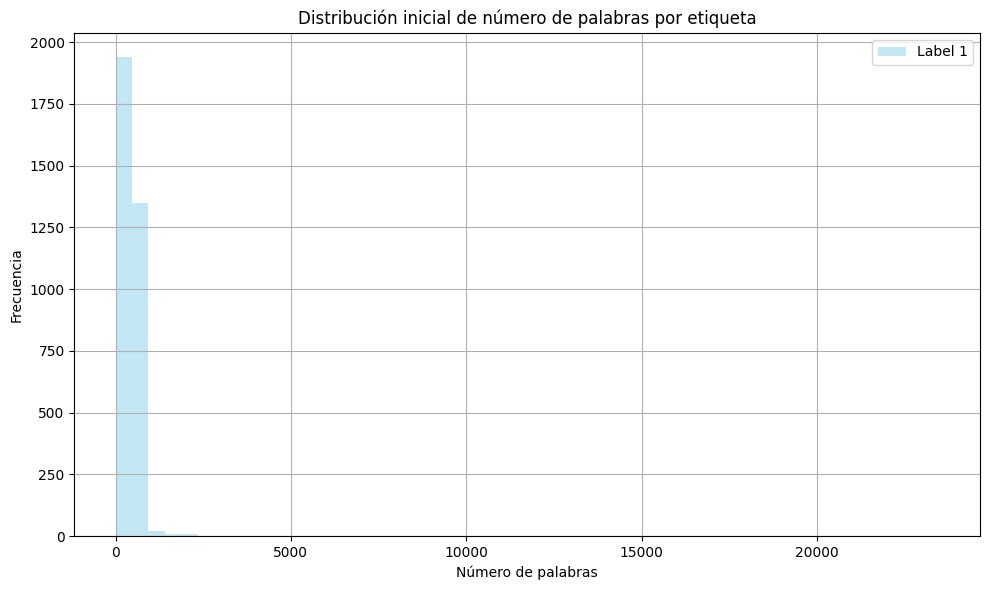

In [46]:
plot_word_count_histogram(df_nigerian,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


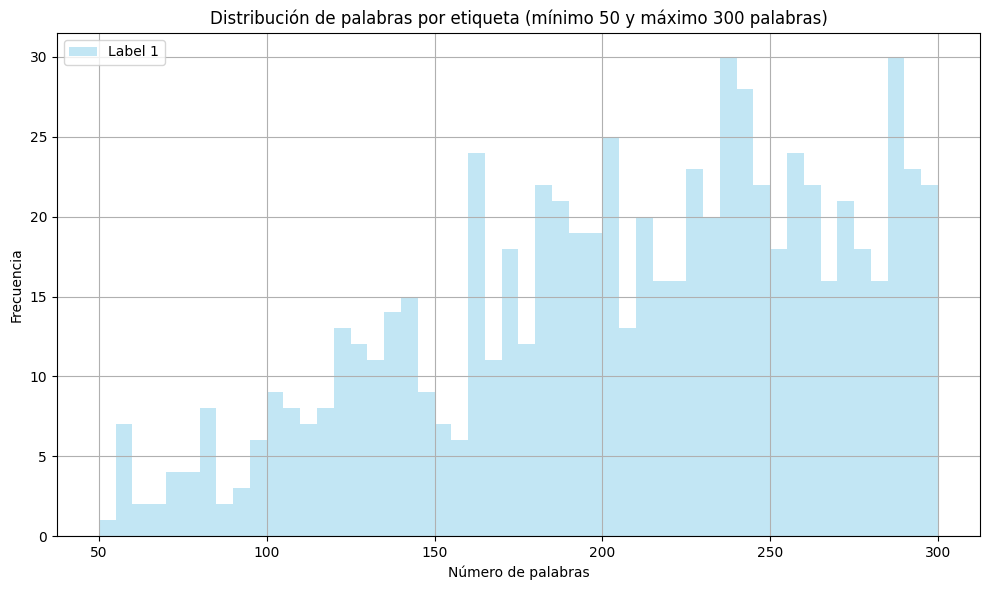

Número de instancias tras filtrado: 727


In [47]:
df_nigerian_filtered = df_nigerian[
    (df_nigerian['word_count'] <= MAX_WORDS) &
    (df_nigerian['word_count'] >= MIN_WORDS)
].copy()

df_nigerian_filtered['language'] = df_nigerian_filtered['body'].apply(detect_language)
df_nigerian_filtered = df_nigerian_filtered[df_nigerian_filtered['language'] == 'en']

plot_word_count_histogram(
    df_nigerian_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_nigerian_filtered.shape[0]}")

Seleccionamos los correos que necesitamos de cada tipo de forma aleatoria.


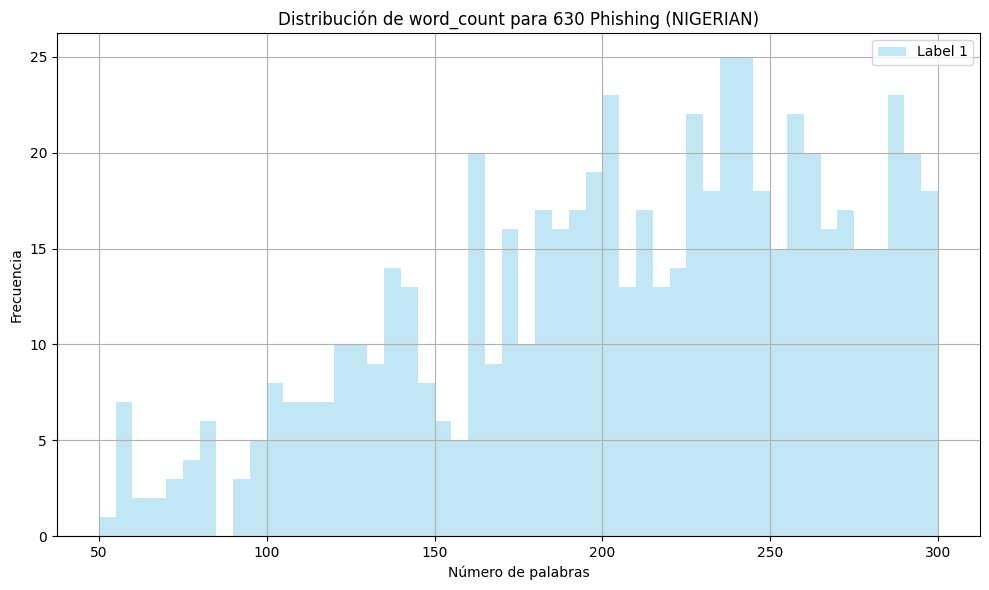

In [48]:
df_nigerian = df_nigerian_filtered.sample(n=SAMPLE_SIZE_NIGERIAN, random_state=SEED)

plot_word_count_histogram(df_nigerian, f'Distribución de word_count para {SAMPLE_SIZE_NIGERIAN} Phishing (NIGERIAN)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [49]:
df_nigerian = df_nigerian.drop(columns=['word_count', 'language'])

print(f"{df_nigerian.shape=}")


print("\nDistribución final de etiquetas:")
print(df_nigerian['label'].value_counts())

df_nigerian.shape=(630, 3)

Distribución final de etiquetas:
label
1    630
Name: count, dtype: int64


## NAZARIO

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [50]:
df_nazario = (
    pd.read_csv(DATA_NAZARIO, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

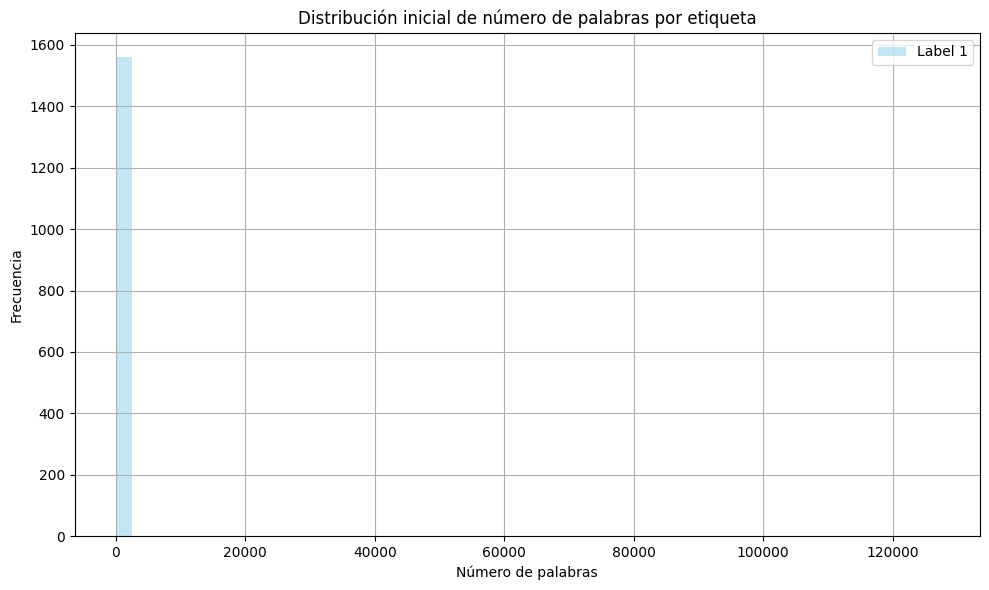

In [51]:
plot_word_count_histogram(df_nazario,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


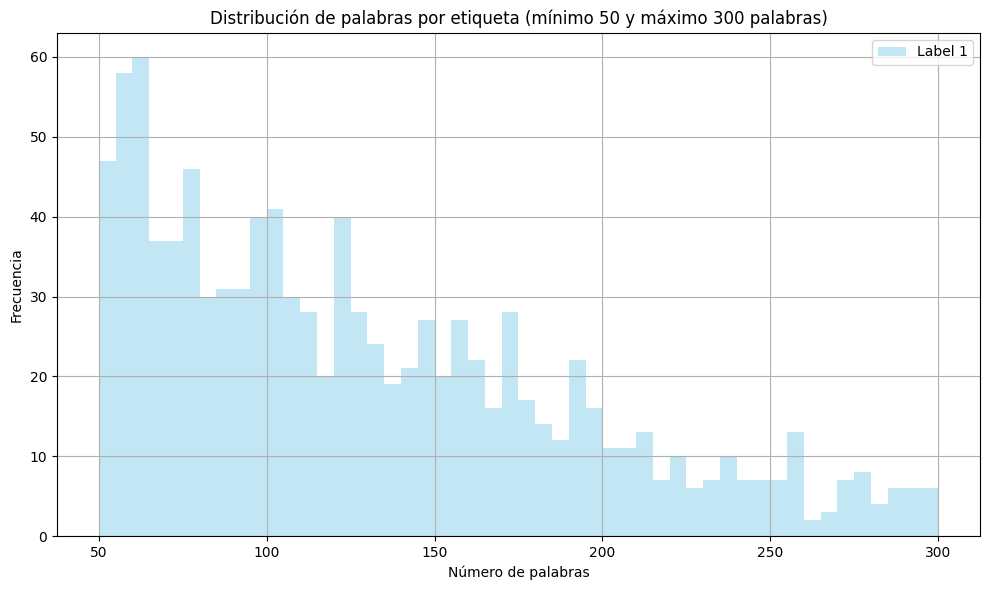

Número de instancias tras filtrado: 1040


In [52]:
df_nazario_filtered = df_nazario[
    (df_nazario['word_count'] <= MAX_WORDS) &
    (df_nazario['word_count'] >= MIN_WORDS)
].copy()

df_nazario_filtered['language'] = df_nazario_filtered['body'].apply(detect_language)
df_nazario_filtered = df_nazario_filtered[df_nazario_filtered['language'] == 'en']

plot_word_count_histogram(
    df_nazario_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_nazario_filtered.shape[0]}")

Seleccionamos los correos que necesitamos de cada tipo de forma aleatoria.

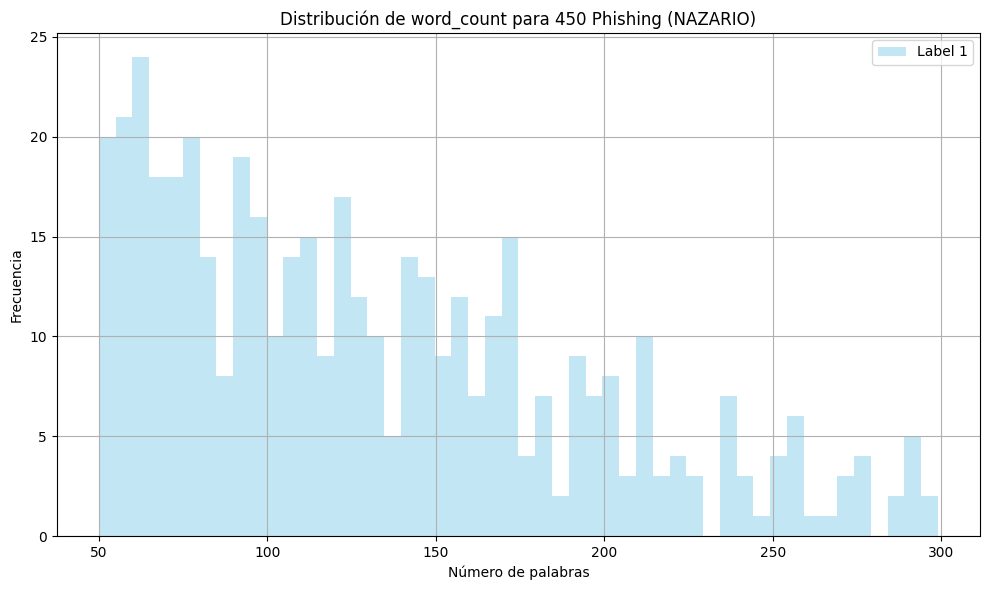

In [53]:
df_nazario = df_nazario_filtered.sample(n=SAMPLE_SIZE_NAZARIO, random_state=SEED)

plot_word_count_histogram(df_nazario, f'Distribución de word_count para {SAMPLE_SIZE_NAZARIO} Phishing (NAZARIO)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [54]:
df_nazario = df_nazario.drop(columns=['word_count', 'language'])

print(f"{df_nazario.shape=}")


print("\nDistribución final de etiquetas:")
print(df_nazario['label'].value_counts())

df_nazario.shape=(450, 3)

Distribución final de etiquetas:
label
1    450
Name: count, dtype: int64


## Concatenación y Unificación de Datasets

Todos los datasets menos el Dataset Phising Pot que por sus características no necesita ser unificado en este paso.

Añadimos una columna `source` para saber de qué dataset proviene cada instancia.

In [55]:
df_trec['source'] = 'TREC'
df_ceas['source'] = 'CEAS'
df_enron['source'] = 'ENRON'
df_spamassasin['source'] = 'SPAMASSASIN'
df_ling['source'] = 'LING'
df_nigerian['source'] = 'NIGERIAN'
df_nazario['source'] = 'NAZARIO'

Y ahora unificamos todos los datasets en un único dataset.

In [56]:
df_all = pd.concat([
    df_trec,
    df_ceas,
    df_enron,
    df_spamassasin,
    df_ling,
    df_nigerian,
    df_nazario
], ignore_index=True)

Verificamos que tengamos el dataset como hemos especificado inicialmente

In [57]:
print(f"{df_all['source'].value_counts()}\n")
print(f"{df_all['label'].value_counts()}\n")

print(f"{df_all.shape=}")
print(f"{df_all.columns=}")

source
TREC           1950
CEAS           1950
ENRON          1950
SPAMASSASIN    1420
NIGERIAN        630
LING            540
NAZARIO         450
Name: count, dtype: int64

label
0    5000
1    3890
Name: count, dtype: int64

df_all.shape=(8890, 4)
df_all.columns=Index(['label', 'subject', 'body', 'source'], dtype='object')


Procedemos a guardarlo como csv

In [58]:
df_all.to_csv(MERGED_DATASET, index=False)

## PHISING POT

Crea un `DataFrame` a partir de los archivos `.eml` de una carpeta y le añade una columna con la cantidad de palabras del cuerpo del correo.


In [59]:
df_phising_pot = create_phishing_dataset(EML_DIR)

df_phising_pot = (
    df_phising_pot
    .assign(
        body=lambda df: df['body'].astype(str).str.replace(
            r"phishingpot",
            PLACEHOLDER_DOMAIN,
            flags=re.IGNORECASE,
            regex=True
        ),
        word_count=lambda df: df['body'].str.split().str.len() # Se recalcula después del reemplazo
    )
)

Visualizamos la distribución inicial de número de palabras por etiqueta

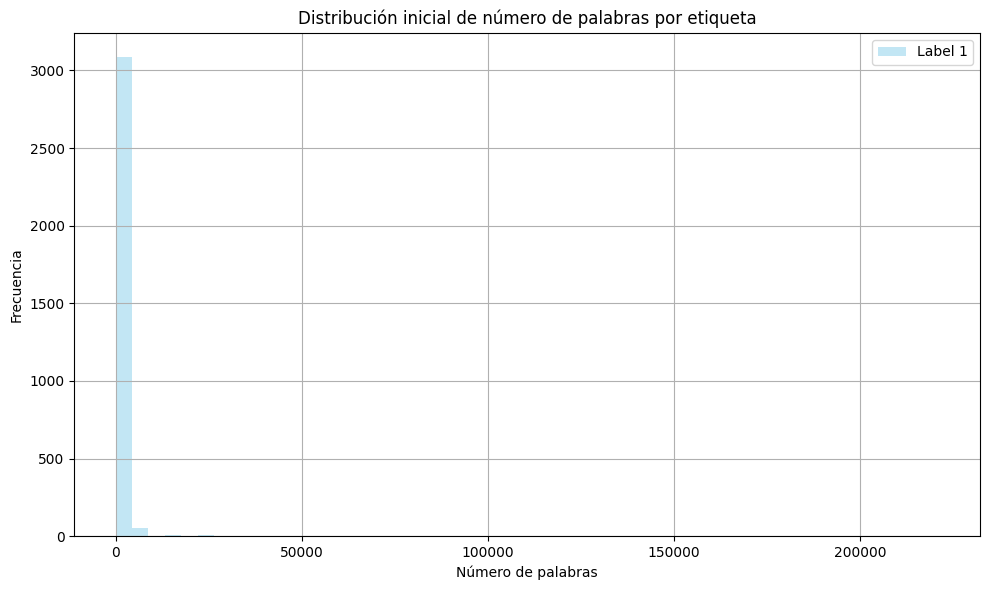

In [60]:
plot_word_count_histogram(df_phising_pot,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un rephrasing efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.

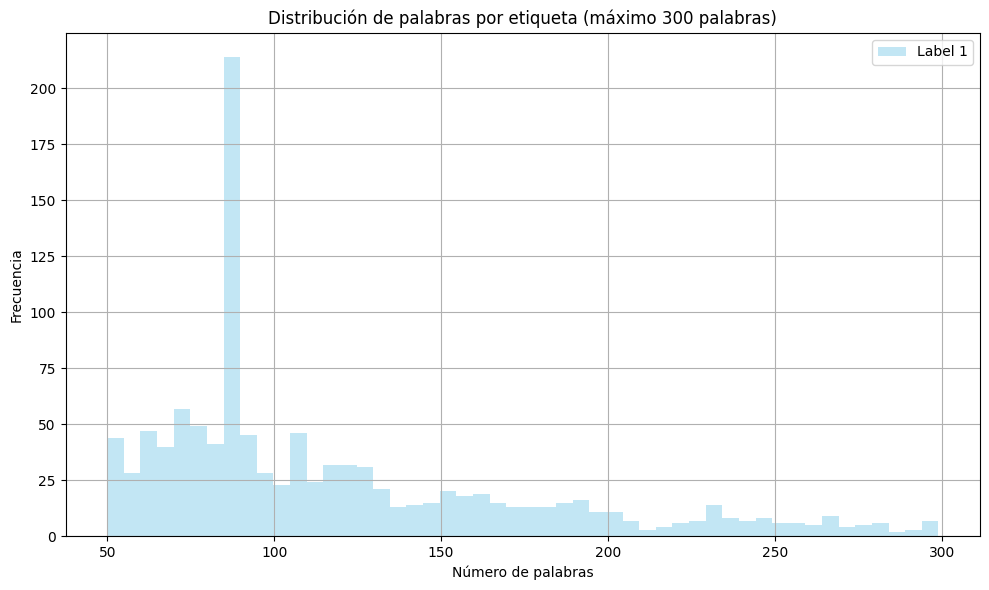

Número de instancias tras filtrado: 1125


In [61]:
df_phising_pot_filtered = df_phising_pot[
    (df_phising_pot['word_count'] <= MAX_WORDS) &
    (MIN_WORDS <= df_phising_pot['word_count'])
].copy()

df_phising_pot_filtered['language'] = df_phising_pot_filtered['body'].apply(detect_language)
df_phising_pot_filtered = df_phising_pot_filtered[df_phising_pot_filtered['language'] == 'en']

plot_word_count_histogram(
    df_phising_pot_filtered,
    f'Distribución de palabras por etiqueta (máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_phising_pot_filtered.shape[0]}")

Seleccionamos los correos que necesitamos de cada tipo de forma aleatoria.

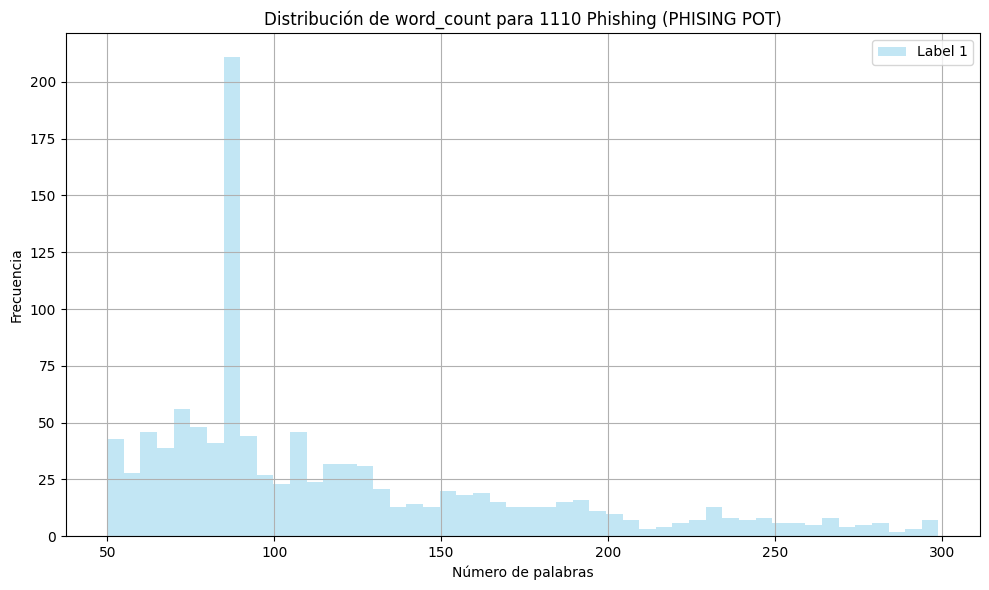

In [62]:
df_phising_pot = df_phising_pot_filtered.sample(n=SAMPLE_SIZE_PHISING_POT, random_state=SEED)

plot_word_count_histogram(df_phising_pot, f'Distribución de word_count para {SAMPLE_SIZE_PHISING_POT} Phishing (PHISING POT)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.

En este caso debido a que Phising Pot lo cogemos con archivos `.eml` podemos sacar más columnas y no quedarnos únicamente con subject, body y label.

En el siguiente notebook sacaremos esas mismas características para *emails_unificados.csv* donde se ubican el resto del dataset ya unificado.

In [63]:
df_phising_pot = df_phising_pot.drop(columns=['word_count', 'language'])

print(f"{df_phising_pot.shape=}")


print("\nDistribución final de etiquetas:")
print(df_phising_pot['label'].value_counts())

df_phising_pot.shape=(1110, 7)

Distribución final de etiquetas:
label
1    1110
Name: count, dtype: int64


In [68]:
print(df_phising_pot.columns)

Index(['subject', 'body', 'has_attachment', 'contains_html', 'source', 'label',
       'urls'],
      dtype='object')


Guardamos el dataset Phising Pot por separado.

In [64]:
df_phising_pot.to_csv(DATA_PHISING_POT, index=False)